In [3]:
import ast
import math
import pickle
import random
import json
import warnings
from collections import Counter, deque
import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    accuracy_score, average_precision_score, f1_score,
    precision_score, recall_score, roc_auc_score, classification_report,
    precision_recall_curve
)
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
)

# %load_ext autoreload
# %autoreload 2
from utils import *

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ontology = 'BPO'
ontology_type = 'process'

test_embeddings_path = r'processed_data_90_30/{0}_test.npy'.format(ontology_type)
test_tsv_path = r'processed_data_90_30/{0}_test.tsv'.format(ontology_type)


test_embeddings = np.load(test_embeddings_path)
test_GO_df, test_embeddings, test_GO_list, test_GO_annotated = process_GO_data(test_tsv_path, test_embeddings)

print("test embeddings shape:", test_embeddings.shape)

#bring in the mlb from pkl 
with open('{0}_mlb.pkl'.format(ontology_type), 'rb') as f:
    mlb = pickle.load(f)

test_labels = mlb.transform(test_GO_list)

print("test labels shape:", test_labels.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float).to(device),
                                   torch.tensor(test_labels, dtype=torch.float).to(device))

test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

test embeddings shape: (26746, 512)
test labels shape: (26746, 1548)
Using device: cpu


In [5]:
#use batched medians and mad 
# mad = chunked_mad_over_runs(probs, chunk_size=50)
# median = chunked_median_over_runs(probs, chunk_size=50)

#open mf_uncertainty_results/arrays/ensemble_20_central.npy
with open(r'bp_uncertainty_results/arrays/ensemble_20_central.npy', 'rb') as f:
    median = np.load(f, allow_pickle=True)

#mf_uncertainty_results/arrays/ensemble_20_uncertainty.npy
with open(r'bp_uncertainty_results/arrays/ensemble_20_uncertainty.npy', 'rb') as f:
    mad = np.load(f, allow_pickle=True)

print(median.shape)
print(mad.shape)


(26746, 1548)
(26746, 1548)


In [6]:
#read in processed_data_90_30/trained_function_ALL_data_ancestors_dict.json
with open(r'processed_data_90_30/trained_process_ALL_data_ancestors_dict.json') as f:
    trained_function_ALL_data_ancestors_dict = json.load(f)

#TERMS_NOT_IN_test are terms are where 0 in test_labels
terms_not_in_test = test_labels.sum(axis=0) == 0
terms_not_in_test = np.where(terms_not_in_test)[0]
print("Number of terms not in test:", len(terms_not_in_test))
#get the terms from the mlb 
terms_not_in_test = mlb.classes_[terms_not_in_test]

terms_in_test = test_labels.sum(axis=0) != 0
terms_in_test = np.where(terms_in_test)[0]
print("Number of terms in test:", len(terms_in_test))
#get the terms from the mlb
terms_in_test = mlb.classes_[terms_in_test]

terms_not_in_test, terms_in_test

Number of terms not in test: 169
Number of terms in test: 1379


(array(['GO:0000255', 'GO:0000729', 'GO:0000910', 'GO:0006020',
        'GO:0006083', 'GO:0006145', 'GO:0006152', 'GO:0006166',
        'GO:0006244', 'GO:0006270', 'GO:0006274', 'GO:0006359',
        'GO:0006404', 'GO:0006451', 'GO:0006493', 'GO:0006527',
        'GO:0006546', 'GO:0006548', 'GO:0006554', 'GO:0006562',
        'GO:0006568', 'GO:0006690', 'GO:0006740', 'GO:0006848',
        'GO:0006863', 'GO:0008203', 'GO:0008215', 'GO:0008277',
        'GO:0008614', 'GO:0008643', 'GO:0008655', 'GO:0009086',
        'GO:0009095', 'GO:0009143', 'GO:0009149', 'GO:0009157',
        'GO:0009162', 'GO:0009176', 'GO:0009177', 'GO:0009186',
        'GO:0009189', 'GO:0009196', 'GO:0009197', 'GO:0009200',
        'GO:0009211', 'GO:0009212', 'GO:0009213', 'GO:0009219',
        'GO:0009221', 'GO:0009223', 'GO:0009263', 'GO:0009264',
        'GO:0009265', 'GO:0009304', 'GO:0009394', 'GO:0009396',
        'GO:0009435', 'GO:0009448', 'GO:0009566', 'GO:0009636',
        'GO:0010138', 'GO:0015851', 'GO:

In [7]:
#using obonet read in the ontology
import obonet
go_graph = obonet.read_obo('go-basic.obo')
# Filter to include only GO terms (those starting with 'GO:')
go_graph = nx.subgraph_view(go_graph, filter_node=lambda n: n.startswith("GO:"))

# Get a topological order of GO terms
sorted_go_terms = list(nx.topological_sort(go_graph))

# Create a mapping from GO term to its order index
go_order = {term: idx for idx, term in enumerate(sorted_go_terms)}

# Now, for each ancestor list in your dictionary, sort it based on the GO order.
sorted_trained_function_ALL_data_ancestors_dict = {}

for term, ancestors in trained_function_ALL_data_ancestors_dict.items():
    # Sort the list of ancestors using the go_order dictionary.
    # Terms not found in go_order will get a default value (e.g., float('inf')).
    sorted_ancestors = sorted(ancestors, key=lambda t: go_order.get(t, float('inf')))
    sorted_trained_function_ALL_data_ancestors_dict[term] = sorted_ancestors

# To see the sorted ancestor lists:
for term, sorted_ancestors in sorted_trained_function_ALL_data_ancestors_dict.items():
    print(f"{term}: {sorted_ancestors}")

GO:0006672: ['GO:0006672', 'GO:0006665', 'GO:0043603', 'GO:0006643', 'GO:0006629', 'GO:0044238', 'GO:0008152', 'GO:0009987', 'GO:0008150']
GO:0043574: ['GO:0043574', 'GO:0046907', 'GO:0051649', 'GO:0051641', 'GO:0006810', 'GO:0051234', 'GO:0051179', 'GO:0009987', 'GO:0008150']
GO:0006749: ['GO:0006749', 'GO:0006575', 'GO:0043603', 'GO:0006790', 'GO:0008152', 'GO:0009987', 'GO:0008150']
GO:0170041: ['GO:0170041', 'GO:0006520', 'GO:0019752', 'GO:0043436', 'GO:0006082', 'GO:0044281', 'GO:0044238', 'GO:0008152', 'GO:0009987', 'GO:0008150']
GO:0170038: ['GO:0170038', 'GO:0170039', 'GO:0046394', 'GO:0016053', 'GO:0006520', 'GO:0019752', 'GO:0044283', 'GO:0043436', 'GO:0006082', 'GO:0044249', 'GO:0044281', 'GO:0044238', 'GO:0009058', 'GO:0008152', 'GO:0009987', 'GO:0008150']
GO:0046036: ['GO:0046036', 'GO:0009208', 'GO:0009218', 'GO:0009147', 'GO:0006220', 'GO:0072527', 'GO:0009199', 'GO:0009259', 'GO:0009141', 'GO:0009117', 'GO:0019693', 'GO:1901135', 'GO:0006753', 'GO:0006796', 'GO:0019637'

In [8]:
#filter sorted_ancestors for mlb.classes_
sorted_trained_function_ALL_data_ancestors_dict = {term: [a for a in ancestors if a in mlb.classes_] for term, ancestors in sorted_trained_function_ALL_data_ancestors_dict.items()}
sorted_trained_function_ALL_data_ancestors_dict

{'GO:0006672': ['GO:0006672',
  'GO:0006665',
  'GO:0043603',
  'GO:0006643',
  'GO:0006629',
  'GO:0044238',
  'GO:0008152',
  'GO:0009987',
  'GO:0008150'],
 'GO:0043574': ['GO:0043574',
  'GO:0046907',
  'GO:0051649',
  'GO:0051641',
  'GO:0006810',
  'GO:0051234',
  'GO:0051179',
  'GO:0009987',
  'GO:0008150'],
 'GO:0006749': ['GO:0006749',
  'GO:0006575',
  'GO:0043603',
  'GO:0006790',
  'GO:0008152',
  'GO:0009987',
  'GO:0008150'],
 'GO:0170041': ['GO:0170041',
  'GO:0006520',
  'GO:0019752',
  'GO:0043436',
  'GO:0006082',
  'GO:0044281',
  'GO:0044238',
  'GO:0008152',
  'GO:0009987',
  'GO:0008150'],
 'GO:0170038': ['GO:0170038',
  'GO:0170039',
  'GO:0046394',
  'GO:0016053',
  'GO:0006520',
  'GO:0019752',
  'GO:0044283',
  'GO:0043436',
  'GO:0006082',
  'GO:0044249',
  'GO:0044281',
  'GO:0044238',
  'GO:0009058',
  'GO:0008152',
  'GO:0009987',
  'GO:0008150'],
 'GO:0046036': ['GO:0046036',
  'GO:0009208',
  'GO:0009218',
  'GO:0009147',
  'GO:0006220',
  'GO:0072527',

In [8]:
closest_terms_sorted = {}
for term in terms_not_in_test:
    closest = find_closest_term_from_sorted(term, set(terms_in_test), sorted_trained_function_ALL_data_ancestors_dict)
    closest_terms_sorted[term] = closest

for term, closest in closest_terms_sorted.items():
    if closest is not None:
        print(f"For term {term}, the closest valid term (using sorted ancestors) is {closest}")
    else:
        print(f"For term {term}, no valid term was found from the sorted ancestors.")


For term GO:0000255, the closest valid term (using sorted ancestors) is GO:0043603
For term GO:0000729, the closest valid term (using sorted ancestors) is GO:0006259
For term GO:0000910, the closest valid term (using sorted ancestors) is GO:0022402
For term GO:0006020, the closest valid term (using sorted ancestors) is GO:0019751
For term GO:0006083, the closest valid term (using sorted ancestors) is GO:0032787
For term GO:0006145, the closest valid term (using sorted ancestors) is GO:0006144
For term GO:0006152, the closest valid term (using sorted ancestors) is GO:0009164
For term GO:0006166, the closest valid term (using sorted ancestors) is GO:0046129
For term GO:0006244, the closest valid term (using sorted ancestors) is GO:0072529
For term GO:0006270, the closest valid term (using sorted ancestors) is GO:0006259
For term GO:0006274, the closest valid term (using sorted ancestors) is GO:0006259
For term GO:0006359, the closest valid term (using sorted ancestors) is GO:0006355
For 

Tuning lambda:   5%|▌         | 1/20 [00:08<02:39,  8.40s/it]

Lambda: 0.10, Valid terms: 1221 out of 1548


Tuning lambda:  10%|█         | 2/20 [00:16<02:28,  8.26s/it]

Lambda: 0.20, Valid terms: 1220 out of 1548


Tuning lambda:  15%|█▌        | 3/20 [00:24<02:19,  8.18s/it]

Lambda: 0.30, Valid terms: 1223 out of 1548


Tuning lambda:  20%|██        | 4/20 [00:32<02:10,  8.16s/it]

Lambda: 0.40, Valid terms: 1219 out of 1548


Tuning lambda:  25%|██▌       | 5/20 [00:40<02:02,  8.15s/it]

Lambda: 0.50, Valid terms: 1220 out of 1548


Tuning lambda:  30%|███       | 6/20 [00:48<01:52,  8.05s/it]

Lambda: 0.60, Valid terms: 1223 out of 1548


Tuning lambda:  35%|███▌      | 7/20 [00:56<01:43,  7.94s/it]

Lambda: 0.70, Valid terms: 1219 out of 1548


Tuning lambda:  40%|████      | 8/20 [01:04<01:34,  7.85s/it]

Lambda: 0.80, Valid terms: 1218 out of 1548


Tuning lambda:  45%|████▌     | 9/20 [01:11<01:25,  7.79s/it]

Lambda: 0.90, Valid terms: 1217 out of 1548


Tuning lambda:  50%|█████     | 10/20 [01:19<01:17,  7.71s/it]

Lambda: 1.00, Valid terms: 1222 out of 1548


Tuning lambda:  55%|█████▌    | 11/20 [01:26<01:08,  7.63s/it]

Lambda: 1.10, Valid terms: 1222 out of 1548


Tuning lambda:  60%|██████    | 12/20 [01:34<01:00,  7.54s/it]

Lambda: 1.20, Valid terms: 1217 out of 1548


Tuning lambda:  65%|██████▌   | 13/20 [01:41<00:52,  7.47s/it]

Lambda: 1.30, Valid terms: 1212 out of 1548


Tuning lambda:  70%|███████   | 14/20 [01:48<00:44,  7.43s/it]

Lambda: 1.40, Valid terms: 1198 out of 1548


Tuning lambda:  75%|███████▌  | 15/20 [01:56<00:37,  7.43s/it]

Lambda: 1.50, Valid terms: 1188 out of 1548


Tuning lambda:  80%|████████  | 16/20 [02:03<00:29,  7.39s/it]

Lambda: 1.60, Valid terms: 1188 out of 1548


Tuning lambda:  85%|████████▌ | 17/20 [02:10<00:22,  7.35s/it]

Lambda: 1.70, Valid terms: 1178 out of 1548


Tuning lambda:  90%|█████████ | 18/20 [02:18<00:14,  7.33s/it]

Lambda: 1.80, Valid terms: 1177 out of 1548


Tuning lambda:  95%|█████████▌| 19/20 [02:25<00:07,  7.30s/it]

Lambda: 1.90, Valid terms: 1166 out of 1548


Tuning lambda: 100%|██████████| 20/20 [02:32<00:00,  7.63s/it]


Lambda: 2.00, Valid terms: 1153 out of 1548

Best lambda is 0.30 with 1223 valid terms.


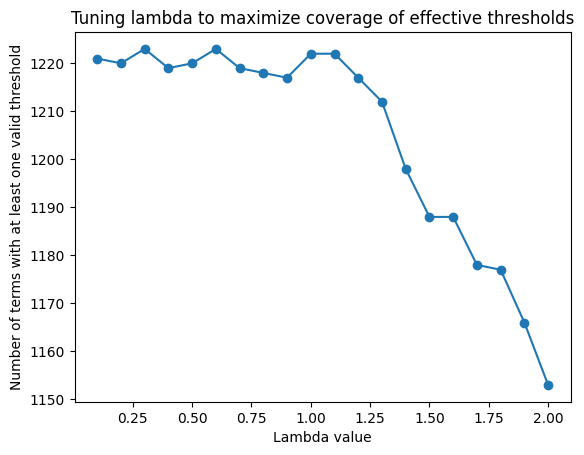

In [9]:
# Define candidate thresholds and target FDR values.
candidate_thresholds = np.arange(0.01, 1.0, 0.1)
#target_fdrs are between 0.01 and 0.5 in steps of 0.1 
target_fdrs = np.arange(0.01, 0.61, 0.1)

# Define a range of lambda values to try.
lambda_values = np.linspace(0.1, 2.0, 20)  # adjust as needed

results = {}
for lambda_val in tqdm(lambda_values, desc="Tuning lambda"):
    valid_count, _ = count_valid_terms(lambda_val, median, mad, test_labels, candidate_thresholds, target_fdrs)
    results[lambda_val] = valid_count
    print(f"Lambda: {lambda_val:.2f}, Valid terms: {valid_count} out of {test_labels.shape[1]}")

# Choose lambda that maximizes valid_count.
best_lambda = max(results, key=results.get)
print(f"\nBest lambda is {best_lambda:.2f} with {results[best_lambda]} valid terms.")

# Plot lambda vs. number of valid terms.
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel("Lambda value")
plt.ylabel("Number of terms with at least one valid threshold")
plt.title("Tuning lambda to maximize coverage of effective thresholds")
plt.show()


In [10]:
# Define candidate thresholds and target FDRs
candidate_thresholds = np.arange(0.01, 1.0, 0.01)
target_fdrs = np.arange(0.01, 0.5, 0.01)

# Compute effective thresholds for all terms
effective_thresholds = compute_all_effective_thresholds(
    median, 
    mad,
    test_labels, 
    candidate_thresholds, 
    target_fdrs, 
    lambda_val=1, 
    smoothing=1e-6
)

Computing effective thresholds: 100%|██████████| 1548/1548 [06:33<00:00,  3.93it/s]


In [11]:
#replace key names of effective_thresholds with GO terms from mlb.classes_
effective_thresholds = {mlb.classes_[k]: v for k, v in effective_thresholds.items()} 

In [12]:
for term, closest in closest_terms_sorted.items():
    if closest is not None:
        print(f"Updating thresholds for {term} using closest valid term {closest}")
        effective_thresholds[term] = effective_thresholds[closest]
    else:
        print(f"No valid closest term found for {term}. Thresholds remain unchanged.")


Updating thresholds for GO:0000255 using closest valid term GO:0043603
Updating thresholds for GO:0000729 using closest valid term GO:0006259
Updating thresholds for GO:0000910 using closest valid term GO:0022402
Updating thresholds for GO:0006020 using closest valid term GO:0019751
Updating thresholds for GO:0006083 using closest valid term GO:0032787
Updating thresholds for GO:0006145 using closest valid term GO:0006144
Updating thresholds for GO:0006152 using closest valid term GO:0009164
Updating thresholds for GO:0006166 using closest valid term GO:0046129
Updating thresholds for GO:0006244 using closest valid term GO:0072529
Updating thresholds for GO:0006270 using closest valid term GO:0006259
Updating thresholds for GO:0006274 using closest valid term GO:0006259
Updating thresholds for GO:0006359 using closest valid term GO:0006355
Updating thresholds for GO:0006404 using closest valid term GO:0051170
Updating thresholds for GO:0006451 using closest valid term GO:0006414
Updati

In [13]:
#save effective_thresholds
with open('effective_thresholds_ensemble20_{0}.json'.format(ontology_type), 'w') as f:
    json.dump(effective_thresholds, f)

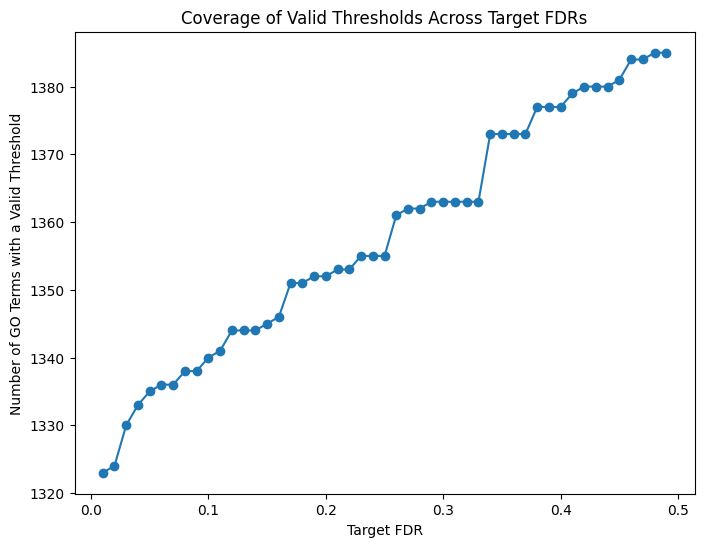

In [14]:
df = pd.DataFrame.from_dict(effective_thresholds, orient='index')
df = df.astype(float)  # Convert all values to float; None becomes NaN
# Calculate coverage: for each target FDR, count terms with a non-NaN threshold.
coverage = df.notna().sum(axis=0)  # Sum non-NaN values per column

plt.figure(figsize=(8, 6))
plt.plot(coverage.index.astype(float), coverage.values, marker='o')
plt.xlabel("Target FDR")
plt.ylabel("Number of GO Terms with a Valid Threshold")
plt.title("Coverage of Valid Thresholds Across Target FDRs")
plt.show()


In [15]:
# Load the ensemble_20_metrics.csv file and create the proper DataFrame
ensemble_metrics = pd.read_csv('bp_uncertainty_results/metrics/ensemble_20_metrics.csv')

# Create thresholds array matching the uncertainty analysis (0.01 to 0.99 in steps of 0.01)
thresholds = np.round(np.arange(0.01, 1.00, 0.01), 2)

# Create the test_df DataFrame with Threshold and FDR columns
test_df = pd.DataFrame({
    'Threshold': thresholds,
    'FDR': ensemble_metrics['fdr'].values
})

print(f"Created DataFrame with {len(test_df)} threshold-FDR pairs")
print(f"Threshold range: {test_df['Threshold'].min():.2f} to {test_df['Threshold'].max():.2f}")
print(f"FDR range: {test_df['FDR'].min():.4f} to {test_df['FDR'].max():.4f}")

# Now find global thresholds for desired FDR targets
fdr_targets = [0.01, 0.05, 0.10]

global_thresholds = {}
for fdr_t in fdr_targets:
    global_thresholds[fdr_t] = find_global_threshold_for_fdr(test_df, fdr_t)

print("\nGlobal thresholds for desired FDRs:")
for k, v in global_thresholds.items():
    print(f"FDR={k:.0%}, threshold ~ {v:.2f}")
    
# Show the actual FDR achieved at each threshold
print("\nActual FDR achieved:")
for fdr_target, threshold in global_thresholds.items():
    actual_fdr = test_df[test_df['Threshold'] == threshold]['FDR'].iloc[0]
    print(f"Target FDR={fdr_target:.0%}, Threshold={threshold:.2f}, Actual FDR={actual_fdr:.4f} ({actual_fdr:.2%})")


Created DataFrame with 99 threshold-FDR pairs
Threshold range: 0.01 to 0.99
FDR range: 0.0021 to 0.3908

Global thresholds for desired FDRs:
FDR=1%, threshold ~ 0.93
FDR=5%, threshold ~ 0.53
FDR=10%, threshold ~ 0.24

Actual FDR achieved:
Target FDR=1%, Threshold=0.93, Actual FDR=0.0095 (0.95%)
Target FDR=5%, Threshold=0.53, Actual FDR=0.0503 (5.03%)
Target FDR=10%, Threshold=0.24, Actual FDR=0.1013 (10.13%)


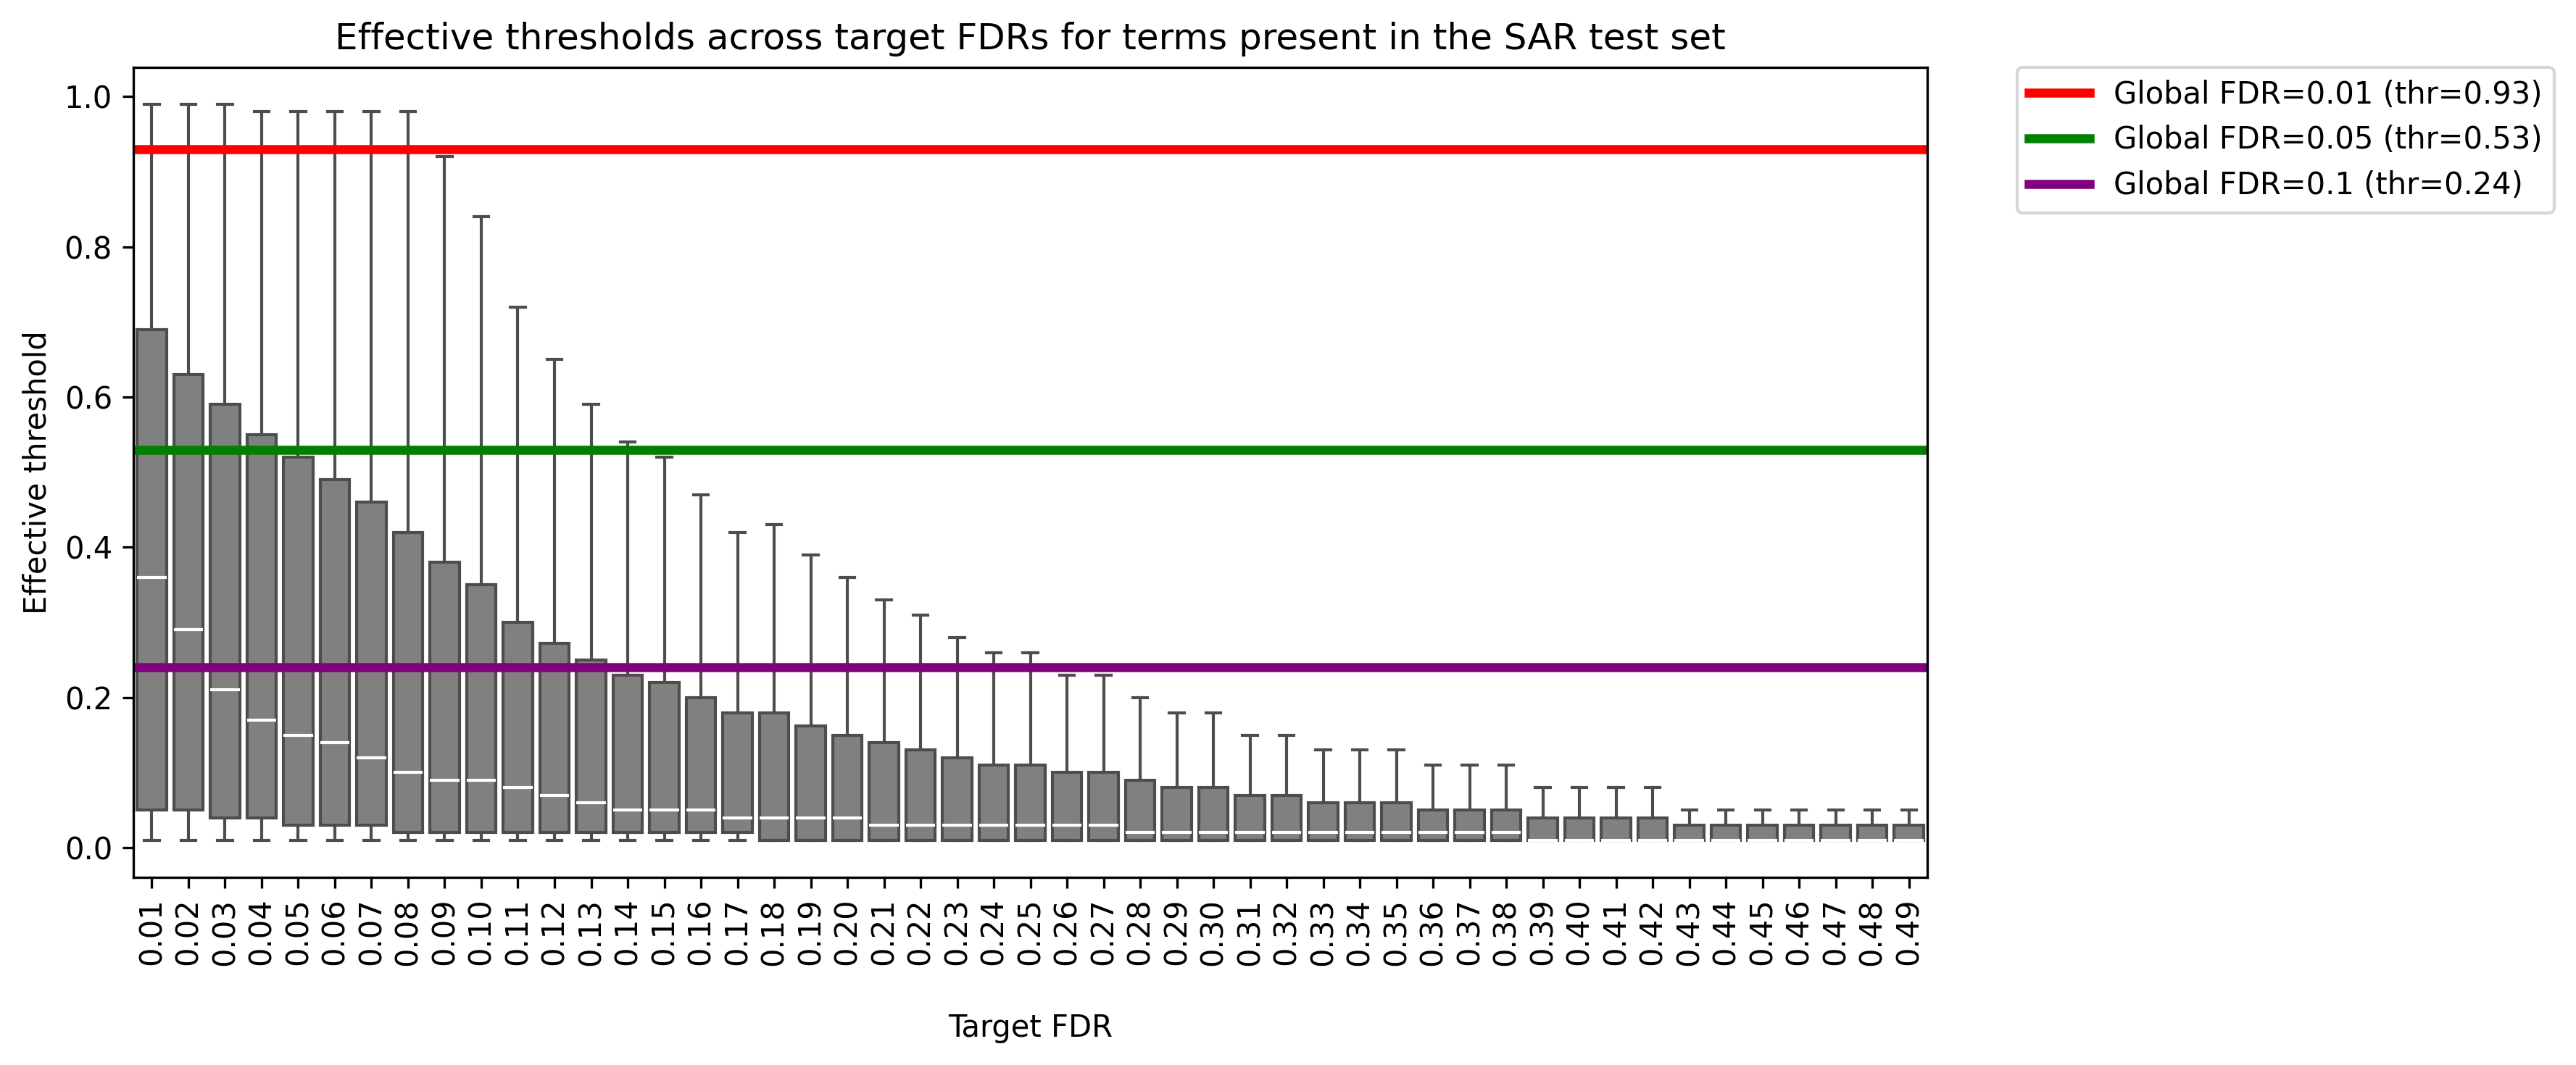

In [17]:
# Create your DataFrame `df` as before.
records = []
for term, fdr_dict in effective_thresholds.items():
    for target_fdr, thr in fdr_dict.items():
        if thr is not None:
            records.append({
                "Term": term,
                "FDR": target_fdr,
                "Threshold": thr
            })
tmp_df = pd.DataFrame(records)

# Sort the unique FDR values.
sorted_fdrs = sorted(tmp_df["FDR"].unique())

plt.figure(figsize=(12, 5),dpi=300)

sns.boxplot(
    x="FDR", 
    y="Threshold", 
    data=tmp_df, 
    order=sorted_fdrs,
    color='grey', 
    medianprops=dict(color="white"),
    showfliers=False
)
# global_thresholds = {0.05: 0.92, 0.10: 0.60, 0.20: 0.34}
# Suppose global_thresholds is a dict like {0.05: 0.42, 0.10: 0.13, 0.20: 0.02}
colors = ['red', 'green', 'purple']  # pick colors you like
for (fdr_t, thr), c in zip(global_thresholds.items(), colors):
    plt.axhline(y=thr, color=c, linestyle='-', linewidth=3,
                label=f'Global FDR={fdr_t} (thr={thr:.2f})')

# Customize x-ticks
x_ticks = np.arange(0, len(sorted_fdrs), 1)
plt.xticks(x_ticks, [f"{float(fdr):.2f}" for fdr in sorted_fdrs], rotation=90)

plt.title("Effective thresholds across target FDRs for terms present in the SAR test set")
plt.xlabel("\nTarget FDR")
plt.ylabel("Effective threshold")

# Place legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()
